# AE353 DP4: Drone Race

## System Linearization and State Space Form

In order to have a working controller and observer, the dynamics for the sensors and the controller must be derived. 

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
sym.init_printing()

In [2]:
# Get the gravity in m/s^2
from ae353_quadrotor import get_gravity
planet = "Earth"
grav = get_gravity(planet, verbose=True)

In [3]:
# Mass and moment of inertia of the bus
mass = 0.5    # The mass of the quadrotor in kg
Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.0040  # The mass of the quadrotor in kg
lxy = 0.25    # The x or y distance from the quadrotor frame to the mocap markers in meters
lz = 0.046875 # The z distance from the quadrotor frame to the mocap markers in meters

In [4]:
# Define position
px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

# Define velocity
vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)
print("px, py, pz rate as a function of orientation and body-fixed velocities:")
sym.N(xyz_dot,3)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")
sym.N(v_inB_dot,3)

# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
sym.N(rpy_dot,3)

# Apply Euler's equation to get the time derivative of the angular velocities of the
# quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
print("Time derivative of the angular velocities in the body-fixed frame:")
sym.N(w_inB_dot, 3)

f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

px, py, pz rate as a function of orientation and body-fixed velocities:
Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:
Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:
Time derivative of the angular velocities in the body-fixed frame:


The equations of motion have this form:

$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_x, \tau_y, \tau_z, f_z\right)$$

Here is the function $f$:

In [5]:
sym.N(f,3)

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                   -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)      
⎢                                                                             
⎢                                 1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)    
⎢                                                                             
⎢                            2.0⋅f_z - ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ - 9.81⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                ωₓ + ω_y⋅sin(φ)⋅tan

In [6]:
# Position of markers in body frame
mark1_inB = sym.Matrix([[lxy],
                        [0.],
                        [lz]])
mark2_inB = sym.Matrix([[0.],
                        [lxy],
                        [lz]])
mark3_inB = sym.Matrix([[-lxy],
                        [0.],
                        [lz]])
mark4_inB = sym.Matrix([[0.],
                        [-lxy],
                        [lz]])

# Position of markers in world frame
mark1_inW = p_inW + R_ofB_inW @ mark1_inB
mark2_inW = p_inW + R_ofB_inW @ mark2_inB
mark3_inW = p_inW + R_ofB_inW @ mark3_inB
mark4_inW = p_inW + R_ofB_inW @ mark4_inB

# Sensor model
g = sym.simplify(sym.Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))

This gives us our sensor model. The model has the form:
$$
\begin{bmatrix}
{m_1}_x \\ 
{m_1}_y \\ 
{m_1}_z \\ 
{m_2}_x \\ 
{m_2}_y \\ 
{m_2}_z \\
{m_3}_x \\ 
{m_3}_y \\ 
{m_3}_z \\ 
{m_4}_x \\ 
{m_4}_y \\ 
{m_4}_z \\
\end{bmatrix}= g(p_x, p_y, p_z, \phi, \theta, \psi),
$$
where ${m_i}_j$ is the $j$ coordinate of the $i$th marker in world coordinates. Here is the function $g$:

In [7]:
sym.N(g,3)

⎡              pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.0469⋅sin(θ)⋅cos(φ)⋅cos(ψ) + 0.25⋅
⎢                                                                             
⎢              p_y - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ)⋅cos(φ) + 0.25
⎢                                                                             
⎢                                p_z - 0.25⋅sin(θ) + 0.0469⋅cos(φ)⋅cos(θ)     
⎢                                                                             
⎢pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.25⋅sin(φ)⋅sin(θ)⋅cos(ψ) - 0.25⋅sin(ψ)⋅cos(φ) + 
⎢                                                                             
⎢p_y + 0.25⋅sin(φ)⋅sin(ψ)⋅sin(θ) - 0.0469⋅sin(φ)⋅cos(ψ) + 0.0469⋅sin(ψ)⋅sin(θ)
⎢                                                                             
⎢                             p_z + 0.25⋅sin(φ)⋅cos(θ) + 0.0469⋅cos(φ)⋅cos(θ) 
⎢                                                                             
⎢              pₓ + 0.0469⋅sin(φ)⋅sin(ψ) + 0.0469⋅si

### Finding the equilbrium state
In order to model our system in a standard state space model, we must linearize the dynamics of both the observer and the drone itseelf. The equilibriumstate is when our system reaches a state when it is stable. For a drone, intuitively, this is when the drone is simply hovering. The exact position of the drone does not affect the equilibrium, however, the velocities, angular positions and angular velocities must be at 0. The torques acting on the drone must also be 0, but the $f_z$ must be equivalent to the force of gravity acting on the drone, so it remains hovering. 

In [8]:
# Finding the equilbrium points
px, py, pz, vx, vy, vz, wx, wy, wz = px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, wx_inB, wy_inB, wz_inB # easier to understand
taux, tauy, tauz, fz = taux_inB, tauy_inB, tauz_inB, fz_inB
pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze = 0,0,0,0,0,0,0,0,0,0,0,0
tauxe, tauye, tauze, fze = 0,0,0,9.81/2
f_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f)
# When the values are plugged into the dynamics, we get a zero vector, which means it's at equilbrium
f_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [59]:
# The g matrix we originally had represented the dynamics for a single sensor. We have 4 sensors on our drone, so we must cocatenate all the separate 
# sensors into one matrix
g_ = g
for i in range(3):
    g_.row_join(g)
g_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), g)
q_e = np.array((g_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze))).flatten()
# When we plug in the equilbrium state, but we do not get a zero vector. This is because the 4 sensors are located away from the origin, so their vectors
# represent the positions of the sensors with respect to the origin
sym.Matrix(q_e)

⎡  0.25  ⎤
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢  0.25  ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎣0.046875⎦

### Linearizing the Dynamics
In order to model our system in the standard state space model, we must linearize the dynamics. The dynamics are currently nonlinear, so taking the Jacobians with respect to certain variables will help us put this into state space form. We must compute the Jacobians, then plug in the equilibirum values to find the final matrix.

In [212]:
# Finding the coefficient matrices
# The A matrix represents the coefficient matrix of the dynamics, so we must take the Jacobian of the drone dynamics (f) with respect to the states
A_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f.jacobian([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz]))
A = A_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)
sym.Matrix(A)

⎡0  0  0  1.0   0    0     0     0    0   0    0    0 ⎤
⎢                                                     ⎥
⎢0  0  0   0   1.0   0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0   1.0    0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0    9.81  0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0   -9.81   0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0  1.0   0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0   1.0   0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0   1.0⎥
⎢                                               

In [213]:
# The B matrix represents the coefficient matrix of the control inputs, so we must take the Jacobian of the drone dynamics (f) with respect to 
# the controller inputs
B_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f.jacobian([taux, tauy, tauz, fz]))
B = B_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)
sym.Matrix(B)

⎡       0                 0            0     0 ⎤
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0    2.0⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢       0                 0            0     0 ⎥
⎢                                              ⎥
⎢434.782608695652         0            0     0 ⎥
⎢                                              ⎥
⎢       0          4

In [214]:
# The C matrix represents the coefficient matrix of the observer dynamics, so we must take the Jacobian of the sensor dynamics (g) with respect to 
# the states
C_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), g.jacobian([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz]))
C = C_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)
sym.Matrix(C)

⎡1.0   0    0   0  0  0      0      0.046875    0    0  0  0⎤
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0      0.25   0  0  0⎥
⎢                                                           ⎥
⎢ 0    0   1.0  0  0  0      0       -0.25      0    0  0  0⎥
⎢                                                           ⎥
⎢1.0   0    0   0  0  0      0      0.046875  -0.25  0  0  0⎥
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0        0    0  0  0⎥
⎢                                                           ⎥
⎢ 0    0   1.0  0  0  0    0.25        0        0    0  0  0⎥
⎢                                                           ⎥
⎢1.0   0    0   0  0  0      0      0.046875    0    0  0  0⎥
⎢                                                           ⎥
⎢ 0   1.0   0   0  0  0  -0.046875     0      -0.25  0  0  0⎥
⎢                                                           ⎥
⎢ 0    0

### Checking Controllability and Observability
To ensure our system can be controller, we must create the controllability matrix. This matrix is created using a certain formula which is referenced in our report. For simplicity sake, we used the PyControl library to construct our controllability matrix. If the rank of this matrix is equal to the number of states we have (which is also equal to the number of columns of A), we have a controllable system.

In [217]:
# Checking Controllability
import control as ctrl
W = ctrl.ctrb(A, B)
sym.Matrix(W)

⎡       0                 0            0     0          0                 0   
⎢                                                                             
⎢       0                 0            0     0          0                 0   
⎢                                                                             
⎢       0                 0            0     0          0                 0   
⎢                                                                             
⎢       0                 0            0     0          0                 0   
⎢                                                                             
⎢       0                 0            0     0          0                 0   
⎢                                                                             
⎢       0                 0            0    2.0         0                 0   
⎢                                                                             
⎢       0                 0            0     0   434

In [218]:
# Since this is true, our system is controllable
np.linalg.matrix_rank(W) == A.shape[0]

True

To ensure our system can be controller, we must create the Observability matrix. This matrix is created using a certain formula which is referenced in our report. For simplicity sake, we used the PyControl library to construct our Observability matrix. If the rank of this matrix is equal to the number of states we have (which is also equal to the number of columns of A), we have an observable system.

In [220]:
# Checking Observability
import control as ctrl
O = ctrl.obsv(A, C)
sym.Matrix(O)

⎡1.0   0    0    0    0    0       0      0.046875    0        0         0    
⎢                                                                             
⎢ 0   1.0   0    0    0    0   -0.046875     0      0.25       0         0    
⎢                                                                             
⎢ 0    0   1.0   0    0    0       0       -0.25      0        0         0    
⎢                                                                             
⎢1.0   0    0    0    0    0       0      0.046875  -0.25      0         0    
⎢                                                                             
⎢ 0   1.0   0    0    0    0   -0.046875     0        0        0         0    
⎢                                                                             
⎢ 0    0   1.0   0    0    0     0.25        0        0        0         0    
⎢                                                                             
⎢1.0   0    0    0    0    0       0      0.046875  

In [219]:
# Since this is true, our system is observable
np.linalg.matrix_rank(O) == A.shape[0]

True

## Gain Selection and Controller Design
Now that the dynamics have been linearized and we are now modeling our system in a standard state space form, we can find the gain matrices for both our controller and observer. To find the gains, we decided to use LQR, which minimizes a cost function by finding the solution to the Ricatti equation. We can solve this equation using scipy's solve_continuous_are function. We then multiplying the correct matrices to come up with the gain matrix. We created a function for this process for ease of use. Q and R must be diagonal matrices, so we used np.diag to create the matrices. 

In [17]:
from scipy import linalg
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ B.T @ P
    return K

In [55]:
# We wanted to use the same weights for each type of state. This is because we believed that the weights should be the same for each dimension, but 
# different for each type of state
p_weight = 1/(8**2)
v_weight = 1/(10**2)
angle_weight = 1/(1.5**2)
omega_weight = 1/(10**2)
Qcon = np.diag((p_weight, p_weight, p_weight, v_weight, v_weight, v_weight, angle_weight, angle_weight, angle_weight, omega_weight, omega_weight, omega_weight)) 
Rcon = np.diag((1/(0.03**2), 1/(0.03**2), 1/(0.03**2), 1/(15**2)))

K = lqr(A, B, Qcon, Rcon)
sym.Matrix(K)

⎡-2.1293937137441e-18   -0.00374999999999998  -4.44199060392763e-19   -1.00271
⎢                                                                             
⎢ 0.00375000000000001   1.07867179512967e-18  -6.79239038484412e-20   0.006698
⎢                                                                             
⎢-3.25976155190951e-18  3.95593004694861e-18  -1.98822970787694e-17  -6.095241
⎢                                                                             
⎣-2.30374306054491e-16  1.17513424119074e-14          1.875          -2.530983

2992603e-18   -0.00669858351860874   -1.71735587653067e-17   0.046919295671756
                                                                              
58351860878   -8.97232765104987e-19  -1.78819104613135e-19  4.52944479406434e-
                                                                              
22243388e-18  4.62506187098596e-18   -6.1605786816777e-18   1.17447188772182e-
                                                   

In [54]:
# We kept the Q, R matrices as the identity matrices for simplicity
Qob = np.diag((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
Rob = np.diag((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))

# The parameters we enter for the LQR function have to change due to the differnt cost function used for the observer
L = (lqr(A.T, C.T, np.linalg.inv(Rob), np.linalg.inv(Qob))).T
sym.Matrix(L)

⎡   1.6029062077909     3.42419815333575e-16    -0.190234588600967       1.602
⎢                                                                             
⎢3.45240398767894e-16     1.60290620779089     -2.33966253444588e-16   2.10888
⎢                                                                             
⎢2.98540352686844e-17   -2.18462788811759e-16    0.707106781186548    1.626554
⎢                                                                             
⎢  4.91038697468918     2.85045743565941e-15     -1.25643282154566      4.9103
⎢                                                                             
⎢1.97097322447859e-15     4.91038697468917     -1.17785918040336e-15  1.758020
⎢                                                                             
⎢-3.5376354961972e-17   -5.04661102917314e-16    0.500000000000001    2.392877
⎢                                                                             
⎢-4.0243400114525e-16    -0.828190463834783    1.249

### Creating the Controller
Now to put it all together. We must now design a controller that estimates its position with its sensors while tracking its desired position. All the necessary matrices are initialized in the constructor, including the equilibrium states and inputs and the maximum error. The reset function initializes the xhat (estimation of the staate). The other variables are extra components we added to improve our controller, such as a counter for the number of gates we passed and ways to track the phat and pdes throughout the simulation. In the run function, that is where most of the math is done for the controller. We also implemented collision avoidance so as to avoid other drones when racing against them. This also improved the speed of our controller. 

In [183]:
class Controller():
    def __init__(self):
        # initialzing all the necessary variables
        self.A = A
        self.B = B
        self.C = C

        self.K = K
        self.L = L
        self.m_e = np.array([pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze]) # equilibrium values of the state
        self.n_e = np.array([tauxe, tauye, tauze, fze]) # equilibrium values of the inputs
        self.q_e = q_e # equilibrium values of the sensors
        # found this through testing
        self.e_max = 0.5
        pass

    
    def reset(self):
        self.xhat = np.zeros(12,)  # state estimate
        self.last_p_goal = np.zeros(3) # keeps track of the last position goal from the previous iteration
        self.gate_count = 0 # what number gate we are aiming for
        self.phat_history = np.array([0.,0.,0.]) # history of the estimated pos over time
        self.pdes_history = np.array([0.,0.,0.]) # history of the desired pos over time
        pass
    
    
    def run(self, **kwargs):
        self.dt = kwargs["dt"] # change in time between iterations of the controller
        self.p_goal = kwargs["next_gate"] # position goal which is the position of the center of the next gate
        p_hat = self.xhat[:3] # estimated position
        
        # implement gradient descent for collision avoidance
        k_attract = 20. # the weight for the attraction force of the p_goal
        k_repel = 0. # the weight for the repulsive force of the p_goal (we set this later)
        k_des = 0.5 # the weight for the overall force of the collision avoidance
        r_drone = 0.5 # radius of the drone
        s = r_drone

        # this code increments gate_count when we have a new gate
        p_goal = kwargs['next_gate']
        if (self.last_p_goal[0] == 0 and self.last_p_goal[1] == 0 and self.last_p_goal[2] == 0):
            self.last_p_goal = kwargs['next_gate']
            self.gate_count += 1
        elif (self.last_p_goal[0] != p_goal[0] or self.last_p_goal[1] != p_goal[1] or self.last_p_goal[2] != p_goal[2]):
            self.last_p_goal = kwargs['next_gate']
            self.gate_count += 1

        
        # calculate the attractive force
        if (self.gate_count > 4): # if we are far into the obstacle course, we decrease the k_attract to slow down a bit but increase k_des
            k_des = 1 
            k_attract = 8.
        if (self.gate_count == 6):
            k_attract = 20. # speed up at the long stretch of the obstalce course
            if (np.linalg.norm(p_hat - self.p_goal) < 25):
                k_attract = 7. # sometimes the drone would move too fast and overeact, so we must slow down as it gets closer
    
        if kwargs["is_last_gate"] == True:
            k_attract = 40. # move as fast as possible at the last gate
        
        h_attract = k_attract*((p_hat - self.p_goal) / np.linalg.norm(p_hat - self.p_goal)) # the attractive force calculation

        
        # Calculate the Repulsive Part
        h_repel = np.array([0.0,0.0,0.0]) 
        for q in kwargs["pos_others"]:
            #Repulsion of Other Drones
            p_obst = q + s*((p_hat - q)/np.linalg.norm(p_hat - q))
            grad_d = (p_hat - p_obst)/np.linalg.norm((p_hat - p_obst))
            d_p = np.linalg.norm((p_hat - p_obst))
            k_repel = 6. # k_repel is relatively low because sometimes the drone overracts to other drones near it
            h_repel += -k_repel*((grad_d/(d_p*d_p)))[0]
           
            #If the drone is too close to the floor, get away so we don't crash
            if p_hat[2] < 1.0:
                k_repel = 1.
                h_repel += -k_repel * np.array([0.0,0.0,5.0])
        
        if (self.gate_count > 1): # we turn off repulsive force after the first gate because we watn to focus on being fast after beating the first gate
            h_repel = np.zeros(3)
            
        # Combining the terms
        h = h_attract + h_repel

        # determining the p_des by looking at the error so it doesn't cause our drone to act too aggressively
        if np.linalg.norm(self.p_goal - p_hat) < self.e_max:
            self.p_des = self.p_goal
        else:
            self.p_des = p_hat - k_des*h # gradient descent is applied

        #Calculate x desired
        self.x_des = np.block([self.p_des, np.zeros(9)])

        #Find inputs using tracking and linear feedback
        u = -self.K@(self.xhat - self.x_des)
        inputs = u + self.n_e # adding the eq. control input

        #Update x estimation
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]])
        y = o - self.q_e # finding the sensor measurement and subtracking the equilibrium sensor measurement
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))
        # tracking the phat and pdes
        self.phat_history = np.block([[self.phat_history], [self.xhat[:3]]])
        self.pdes_history = np.block([[self.pdes_history], [self.p_des]])
        
        return inputs

In [184]:
# This is a second controller that we tested against that employs a similar controller
class Controller2():
    def __init__(self):
        self.A = A
        self.B = B
        self.C = C

        self.K = K
        self.L = L
        self.m_e = np.array([pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze])
        self.n_e = np.array([tauxe, tauye, tauze, fze])
        self.q_e = q_e

        self.e_max = 0.5
        pass

    
    def reset(self):
        self.xhat = np.zeros(12,)
        self.n = np.zeros(4,)
        self.last_p_goal = np.zeros(3)
        self.gate_count = 0
        self.phat_history = np.array([0.,0.,0.])
        self.pdes_history = np.array([0.,0.,0.])
        pass
    
    
    def run(self, **kwargs):
        self.dt = kwargs["dt"]
        self.p_goal = kwargs["next_gate"]
        self.p_goal_direction = kwargs["dir_gate"]
        p_hat = self.xhat[:3]
        
        # implement gradient descent for collision avoidance
        k_attract = 5.
        k_repel = 0.5
        k_des = 1.
        r_drone = 0.5
        s = r_drone

    
        if kwargs["is_last_gate"] == True:
            k_attract = 20.
        
        h_attract = k_attract*((p_hat - self.p_goal) / np.linalg.norm(p_hat - self.p_goal))

        
        # Calculate the Repulsive Part
        h_repel = np.array([0.0,0.0,0.0])
        for q in kwargs["pos_others"]:
            
            #Repulsion of Other Drones
            p_obst = q + s*((p_hat - q)/np.linalg.norm(p_hat - q))
            grad_d = (p_hat - p_obst)/np.linalg.norm((p_hat - p_obst))
            d_p = np.linalg.norm((p_hat - p_obst)) #+ r_drone#- r_drone
            k_repel = 6.
            h_repel += -k_repel*((grad_d/(d_p*d_p)))[0]
        
        # Combining the terms
        h = h_attract + h_repel

        # minimize error using gradient descent method
        if np.linalg.norm(self.p_goal - p_hat) < self.e_max:
            self.p_des = self.p_goal
        else:
            self.p_des = p_hat - k_des*h

        #Calculate x desired
        self.x_des = np.block([self.p_des, np.zeros(9)])

        #Find inputs using tracking and linear feedback
        u = -self.K@(self.xhat - self.x_des)
        inputs = u + self.n_e

        #Update x estimation
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]])
        y = o - self.q_e
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))

        self.phat_history = np.block([[self.phat_history], [self.xhat[:3]]])
        self.pdes_history = np.block([[self.pdes_history], [self.p_des]])

        return inputs

In [185]:
# Create an instance of our Controllers
controller1 = Controller()
controller2 = Controller2()

## Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [247]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae353_quadrotor

In [248]:
# Make an instance of the simulator for 1 or 2 quadrotors
# team_list = ["Team Kachow", "the ORB"]
team_list = ["Team Kachow"]
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=False,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes a list of members of the  ``Controller`` class as an argument and returns ``track_stats`` and ``data``. The parameters and return values of ``sim.run()`` are shown below.


> 


In [249]:
# Run the simulation and collect the simulation data
# controllers = [controller1, controller2] if we want 2 controllers
controllers = [controller1]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=30.0,
                              verbose=True)

Team Kachow:0 PASSED GATE 1 IN 2.93s
Team Kachow:0 PASSED GATE 2 IN 5.29s
Team Kachow:0 PASSED GATE 3 IN 7.46s
Team Kachow:0 PASSED GATE 4 IN 10.4s
Team Kachow:0 PASSED GATE 5 IN 14.4s
Team Kachow:0 PASSED GATE 6 IN 20.1s
Team Kachow:0 PASSED GATE 7 IN 21.11s
Team Kachow:0 COMPLETED LAP IN 21.11s


In [250]:
# Print out the track stats for each quadrotor
for i in range(len(track_stats)):
    stat = track_stats[i]
    print("Quadrotor {} completed lap: {}".format(i, stat["completed_lap"]))
    if len(stat["gate_times"]) > 0:
        print("Gate times for Quadrotor {}: {}".format(i, stat["gate_times"]))
    else:
        print("Quadrotor {} passed no gates.".format(i))
    if stat["completed_lap"]:
        print("Lap time for Quadrotor {}: {}".format(i, stat["lap_time"]))
    print("\n")

Quadrotor 0 completed lap: True
Gate times for Quadrotor 0: [2.93, 5.29, 7.46, 10.4, 14.4, 20.1, 21.11]
Lap time for Quadrotor 0: 21.11




Post-processing the simulation data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib and numpy.

In [251]:
import matplotlib.pyplot as plt
import numpy as np

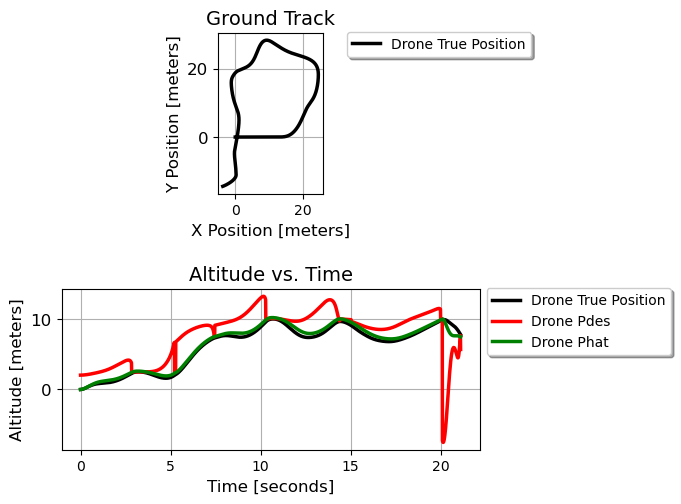

In [252]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
colors = ['k','r','g','b','m','c','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray']
for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])
    
    # Create a plot of the ground path of the quadrotor
    axes[0].plot(pos[:,0], pos[:,1], c=colors[i], lw=2.5, label="Drone True Position")
    
    
    # Create a plot of the altitude versus time
    axes[1].plot(data[0]['time'], pos[:,2], c=colors[i], lw=2.5, label="Drone True Position")
    axes[1].plot(data[0]['time'], controller1.pdes_history[1:,2], c=colors[i+1], lw=2.5, label="Drone Pdes")
    axes[1].plot(data[0]['time'], controller1.phat_history[1:,2], c=colors[i+2], lw=2.5, label="Drone Phat")

# Plots the x position versus the y position
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axes[0].grid()

# plots the z position over time and the desired z estimate
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

From these graphs, in this one iteration of our simualtion, our drone completes the lap. We can also see how the phat and pdes track closely the true position of our drone. This show how well our drone tracked and estimated its own position. 

We can now check our requirements and gather more data. First we will look at how well our drone avoids other drones when racing against them. 

In [256]:
# This function finds the minimum distance between the 2 drones we have in any given simulation
def min_distance_between_drones(data, drone1, drone2):
    min_distance = float('inf')
    
    # Iterate through each timestamp
    for i in range(len(data[drone1]["position"])):
        pos_drone1 = np.array(data[drone1]["position"][i])
        pos_drone2 = np.array(data[drone2]["position"][i])
        
        distance = np.linalg.norm(pos_drone1 - pos_drone2)
        
        if distance < min_distance:
            min_distance = distance
    
    return min_distance

In [ ]:
controller2 = Controller2()
team_list = ["Team Kachow", "the ORB"]
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=2,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=False,
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

controllers = [controller1, controller2]
min_dist = np.zeros(100) # array collecting the data
# we run the simulation 100 times to ensure how controller works every time
for i in range(100):
    (track_stats, data) = sim.run(controllers,
                                  sensor_noise=0.01,
                                  collect_data=True,
                                  max_time=30.0,
                                  verbose=False)
    min_distance = min_distance_between_drones(data, 0, 1)
    min_dist[i] = min_distance


In [ ]:
# Plotting the minimum distance of the simulations
plt.hist(min_dist, bins=20, range=(0, 5), color='blue', edgecolor='black')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (number of simulations)')
plt.title('Histogram of Minimum Distances Between Drones per Simulation')
plt.grid(True)
plt.show()
print(min_dist <= 1)
avg_dist = 0
for i in range(100):
   avg_dist += min_dist[i]
avg_dist = avg_dist / 100
print("Average Minimum Distance from the other drone: ", avg_dist)

From our data it is clear that our drone never comes within 1 meter of the other drone. All of our simulations have a similar minimum distance, but they are all greater than 1 meter. If we also iterate through the minimum distances, we can see that the drone never gets below or equal to 1 meter. Thus, one of our requirements is fulfilled.

Let's now take a look at the requirements we are testing when racing only one drone. 

In [155]:
trials = 100
fail_time = np.zeros(trials) # time it takes for the drone to either end the simulation, or complete a lap
num_laps = 0 # keeping track of laps
controllers = [controller1]
RMSE_x_obs_array = [] # RMSE between the estimated x-position and true x-postiion over time
RMSE_y_obs_array = [] # RMSE between the estimated y-position and true y-postiion over time
RMSE_z_obs_array = [] # RMSE between the estimated z-position and true z-postiion over time

RMSE_x_con_array = [] # RMSE between the desired x-position and true x-postiion over time
RMSE_y_con_array = [] # RMSE between the desired y-position and true y-postiion over time
RMSE_z_con_array = [] # RMSE between the desired z-position and true z-postiion over time

for i in range(trials):
    (track_stats, data) = sim.run(controllers,
                                  sensor_noise=0.01,
                                  collect_data=True,
                                  max_time=30.0,
                                  verbose=False)
    fail_time[i]= data[0]["time"][-1]
    pos = np.array(data[0]['position'])

    RMSE_x = np.sqrt(np.mean(np.square(np.array(pos[:,0]) - np.array(controller1.phat_history[1:,0]))))
    RMSE_x_obs_array.append(RMSE_x)
    RMSE_y = np.sqrt(np.mean(np.square(np.array(pos[:,1]) - np.array(controller1.phat_history[1:,1]))))
    RMSE_y_obs_array.append(RMSE_y)  
    RMSE_z = np.sqrt(np.mean(np.square(np.array(pos[:,2]) - np.array(controller1.phat_history[1:,2]))))
    RMSE_z_obs_array.append(RMSE_z)

    RMSE_x = np.sqrt(np.mean(np.square(np.array(controller1.pdes_history[1:,0]) - np.array(pos[:,0]))))
    RMSE_x_con_array.append(RMSE_x)
    RMSE_y = np.sqrt(np.mean(np.square(np.array(controller1.pdes_history[1:,1]) - np.array(pos[:,1]))))
    RMSE_y_con_array.append(RMSE_y)
    RMSE_z = np.sqrt(np.mean(np.square(np.array(controller1.pdes_history[1:,2]) - np.array(pos[:,2]))))
    RMSE_z_con_array.append(RMSE_z)
    
    if (track_stats[0]["completed_lap"] == True):
        num_laps += 1
    controller1.reset()

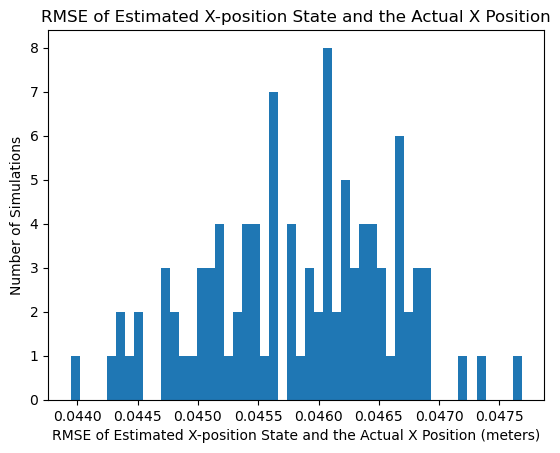

In [225]:
plt.hist(RMSE_x_obs_array,50)
plt.xlabel("RMSE of Estimated X-position State and the Actual X Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Estimated X-position State and the Actual X Position")
plt.plot()

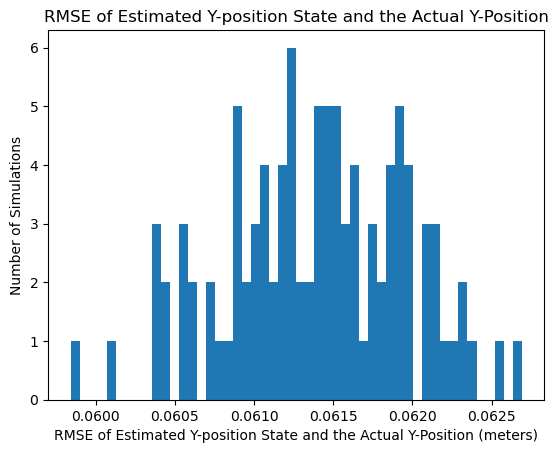

In [226]:
plt.hist(RMSE_y_obs_array,50)
plt.xlabel("RMSE of Estimated Y-position State and the Actual Y-Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Estimated Y-position State and the Actual Y-Position")
plt.plot()

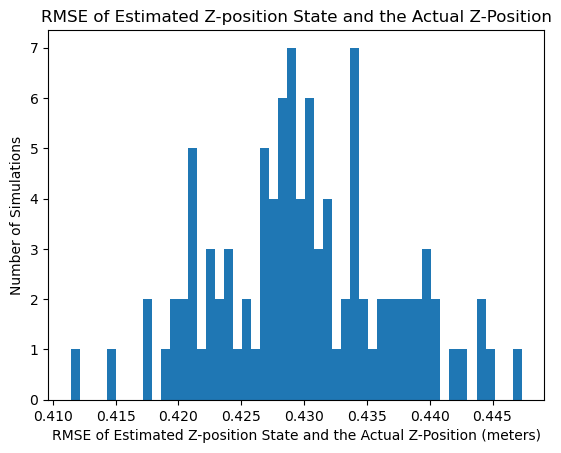

In [227]:
plt.hist(RMSE_z_obs_array,50)
plt.xlabel("RMSE of Estimated Z-position State and the Actual Z-Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Estimated Z-position State and the Actual Z-Position")
plt.plot()

The RMSE is relatively low between the estimated positions and the actual position. This is great, as it means our drone is accurately estimating its position.

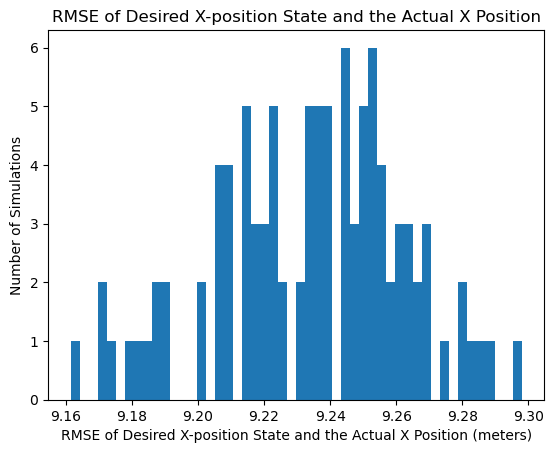

In [228]:
plt.hist(RMSE_x_con_array,50)
plt.xlabel("RMSE of Desired X-position State and the Actual X Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Desired X-position State and the Actual X Position")
plt.plot()

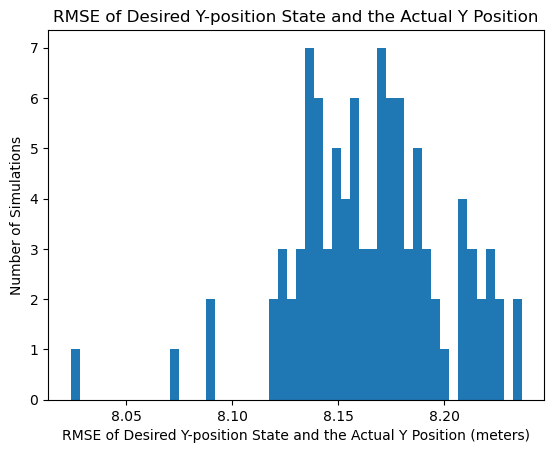

In [254]:
plt.hist(RMSE_y_con_array,50)
plt.xlabel("RMSE of Desired Y-position State and the Actual Y Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Desired Y-position State and the Actual Y Position")
plt.plot()

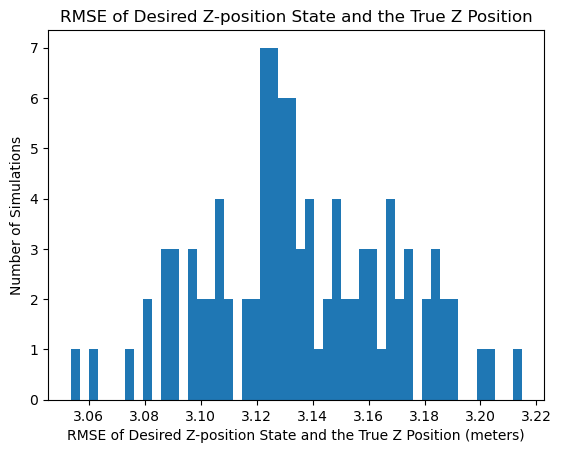

In [253]:
plt.hist(RMSE_z_con_array,50)
plt.xlabel("RMSE of Desired Z-position State and the True Z Position (meters)")
plt.ylabel("Number of Simulations")
plt.title("RMSE of Desired Z-position State and the True Z Position")
plt.plot()

The RMSE between the desired and the true positions are much greater than those of earlier, but this is because desired was always pointing towards the next gate. Since the RMSE isn't greater than 10, this means our controller wasn't too aggressive in its p_des decisions. 

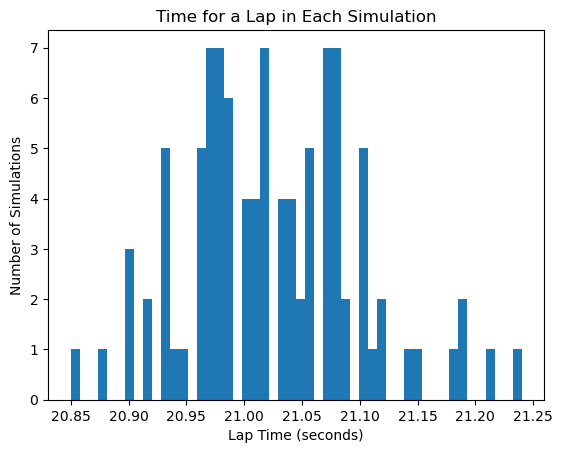

In [231]:
plt.hist(fail_time,50)
plt.xlabel("Lap Time (seconds)")
plt.ylabel("Number of Simulations")
plt.title("Time for a Lap in Each Simulation")
plt.plot()

In [232]:
# If this is true, all simulations were successful
(num_laps == 100)

True